### **Calculando a velocidade espacial em coordenadas galactocentricas usando APOGEE e GAIADR2**
Fredi Quispe H.

Para calcular a velocidade é necessario ter os seguintes parâmetros:

    1 Posição (ascensão recta e declinação)
    2 Movimentos proprios (em ascensão recta e declinação)
    3 Distância
    4 Velocidade Radial

#### **APOGEE DATA**

In [2]:
from IPython.display import IFrame
IFrame(src='https://www.sdss.org/dr14/irspec/spectro_data/', width=1000, height=100)

#### **APOGEE DATA (Informação da tabela de dados)**

In [3]:
from IPython.display import IFrame
IFrame(src='https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/APSTAR_VERS/ASPCAP_VERS/RESULTS_VERS/allStar.html#example', width=1000, height=100)

#### **Lendo o arquivo fits que contem os dados do APOGEE**

In [1]:
# pacotes necessários do python
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt

import astropy.coordinates as coord
import astropy.units as u
# pacote para ler arquivos fits
import fitsio

In [8]:
# Nome do arquivo fits contendo os dados do APOGEE
apogee_data_filename = 'allStar-l31c.2.fits' 
# Selecionando só algumas colunas do arquivo 
column_name_apogee = ['APOGEE_ID','RA', 'DEC', 'VHELIO_AVG', 'VSCATTER', 'VERR', 'PMRA', 'PMDEC', 'SNR'] 
# lendo os dados do arquivo fits (RAD)
RAD = fitsio.read(apogee_data_filename, columns=column_name_apogee) 
RAD = RAD.byteswap().newbyteorder()
# Dados do APOGEE em dataframe do pandas
APOGEE_TABLE_DF = pd.DataFrame.from_records(RAD) 

In [9]:
APOGEE_TABLE_DF.head(5)

,APOGEE_ID,RA,DEC,SNR,VHELIO_AVG,VSCATTER,VERR,PMRA,PMDEC
0,b'VESTA ',0.000000,0.000000,406.069000,15.827300,10.637900,0.008402,-9999.990234,-9999.990234
1,b'2M00000002+7417074',0.000103,74.285408,859.487976,-52.168999,0.158676,0.001012,-2.800000,2.400000
2,b'2M00000019-1924498',0.000832,-19.413851,142.705994,18.649700,0.000000,0.029673,19.600000,-6.500000
3,b'2M00000032+5737103',0.001335,57.619530,215.313004,-20.074600,0.188706,0.037097,0.000000,0.000000
4,b'2M00000032+5737103',0.001335,57.619530,120.399002,-20.759899,0.067132,0.037843,0.000000,0.000000


#### **Eliminando as filas quando o APOGEE_ID se repete, mas mantendo a fila com o maior razão sinal ruido (SNR)**

In [5]:
# apogee data sorting by higuest SNR for duplicate APOGEE_ID
ADSBSNR = APOGEE_TABLE_DF.sort_values('SNR', ascending=False).drop_duplicates('APOGEE_ID').sort_index() 
ADSBSNR.shape
# 18896 estrelas com o mesmo ID

(258475, 7)

In [135]:
# 21 estrelas com velocidade radial desconhecida
ADSBSNR.loc[(ADSBSNR['VHELIO_AVG'] == 9.9999900e+05)].count()

APOGEE_ID     21
RA            21
DEC           21
SNR           21
VHELIO_AVG    21
PMRA          21
PMDEC         21
dtype: int64

In [136]:
SWRV = ADSBSNR.loc[(ADSBSNR['VHELIO_AVG'] != 9.9999900e+05)]

,APOGEE_ID,RA,DEC,SNR,VHELIO_AVG,PMRA,PMDEC
8636,b'AP00421114+4107339',10.546437,41.126087,6.530150e-10,999999.0,-9999.990234,-9999.990234
8780,b'AP00424392+4050270',10.683000,40.840842,1.824410e-01,999999.0,-9999.990234,-9999.990234
8826,b'AP00425893+4109088',10.745537,41.152454,5.619170e-02,999999.0,-9999.990234,-9999.990234
8957,b'AP00432876+4122370',10.869833,41.376944,1.306690e+00,999999.0,-9999.990234,-9999.990234
9036,b'AP00434755+4127080',10.948113,41.452232,3.536960e-11,999999.0,-9999.990234,-9999.990234
9093,b'AP00440263+4125268',11.010958,41.424110,5.704840e-11,999999.0,-9999.990234,-9999.990234
9221,b'AP00444286+4120086',11.178571,41.335731,3.467950e-10,999999.0,-9999.990234,-9999.990234
9283,b'AP00450719+4140311',11.279954,41.675308,2.458540e-01,999999.0,-9999.990234,-9999.990234
73336,b'2M06293017-3122302',97.375720,-31.375076,-1.467850e-10,999999.0,0.000000,0.000000
107004,b'2M09123957+2256456',138.164913,22.946005,-9.633000e-11,999999.0,0.000000,0.000000


In [137]:
# 13 estrelas com velocidade radial (9.9999900e+05), movimento proprio em ascenção reta e declinação desconhecidos (-9999.990234)
ADSBSNR.loc[(ADSBSNR['VHELIO_AVG'] == 9.9999900e+05) & (ADSBSNR['PMRA'] == -9999.990234) & (ADSBSNR['PMDEC'] == -9999.990234)].count()

APOGEE_ID     13
RA            13
DEC           13
SNR           13
VHELIO_AVG    13
PMRA          13
PMDEC         13
dtype: int64

In [138]:
# 2068 estrelas com movimento proprio em ascenção reta e declinação desconhecidos (-9999.990234)
ADSBSNR.loc[(ADSBSNR['PMRA'] == -9999.990234) & (ADSBSNR['PMDEC'] == -9999.990234)].count()

APOGEE_ID     2068
RA            2068
DEC           2068
SNR           2068
VHELIO_AVG    2068
PMRA          2068
PMDEC         2068
dtype: int64

#### **Guardando o novo arquivo em formato fits**
Com o fim de realizar o crossmatch com o catalogo GaiaDR2 será criado um novo arquivo com o nome de apogee_filter_SNR.fits

In [139]:
result_file = fitsio.FITS('apogee_filter_SNR.fits','rw') 
result_file.write(ADSBSNR.to_records(index=False))
result_file.close()

#### **APOGEE e GAIADR2**
A fim de determinar a velocidade espacial em coordenadas galactocentricas é necessário conhecer as distâncias (não fornecido pelo apogee), portanto, os dados do apogee serão complementados com os dados do GAIADR2 que fornece o paralaxe por meio do qual é possível determinar a distância. Com essa finalidade iremos a fazer um crossmatch entre os dos levantamentos. A ferramenta para o crossmatch será feito com TOPCAT (*Tool for Operations on Catalogues And Tables*). Para realizar o crossmatch é necessário definir um radio de match, neste caso iremos usar o radio de 0.5 segundos de arco.

#### **Lendo o arquivo fits apos o crossmatch**
O crossmatch foi feito usando o catálogo contendo as distâncias calculadas a partir da paralaje como mostrado no artigo http://www.mpia.de/~calj/gdr2_distances/gdr2_distances.pdf, mas inicialmente foi realizado um crossmatch com o gaiaDR2 a fim de obter os movimentos proprios que não é dado no catalogo de distâncias localizado no vizier I/347/gaia2dis. O catalogo apos os crossmatch tem o nome APOGEExGAIADR2_dist.fits

In [140]:
apogee_x_gaiadr2_distance_filename = 'APOGEExGAIADR2_dist.fits'
column_name_apogee_gaiadr2_distance = ['APOGEE_ID','RA','DEC', 'PMRA', 'PMDEC','VHELIO_AVG', 'ra_epoch2000', 'dec_epoch2000', 'parallax', 'parallax_error', 'pmra_G', 'pmra_error', 'pmdec_G', 'pmdec_error', 'radial_velocity', 'radial_velocity_error', 'rest', 'b_rest_x', 'B_rest_xa']
AGD = fitsio.read(apogee_x_gaiadr2_distance_filename, ext=1, columns = column_name_apogee_gaiadr2_distance) # Apogee Gaia Distance (AGD)
AGD = AGD.byteswap().newbyteorder()
APO_GAIA_DIST = pd.DataFrame.from_records(AGD)

In [177]:
APO_GAIA_DIST.pmdec_G[86772]

nan

In [192]:
# Essa estrela será analizada independentemente devido a que não apresenta movimento proprio em ascenção recta e declinação no catalogo gaia DR2. 
APO_GAIA_DIST[APO_GAIA_DIST['pmdec_G'].isnull()]

,APOGEE_ID,RA,DEC,VHELIO_AVG,PMRA,PMDEC,ra_epoch2000,dec_epoch2000,parallax,parallax_error,pmra_G,pmra_error,pmdec_G,pmdec_error,radial_velocity,radial_velocity_error,rest,b_rest_x,B_rest_xa
86772,b'2M07414159+3725479',115.423321,37.429985,13.8671,-22.9,1.7,115.423279,37.429952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.143354,117.161026,197.753117


#### **Pasando as colunas do dataframe para arrays**

In [193]:
RA = APO_GAIA_DIST.RA.values
DEC = APO_GAIA_DIST.DEC.values
PMRA = APO_GAIA_DIST.pmra_G.values
PMDEC = APO_GAIA_DIST.pmdec_G.values
VHELIO_AVG = APO_GAIA_DIST.VHELIO_AVG.values
rest = APO_GAIA_DIST.rest.values
ID =  APO_GAIA_DIST.APOGEE_ID

In [194]:
# Rodando o codigo mostrado no site do astropy 
c1 = coord.ICRS(ra=RA*u.degree, dec=DEC*u.degree,
                distance=(rest*u.pc),
                pm_ra_cosdec=PMRA*u.mas/u.yr,
                pm_dec=PMDEC*u.mas/u.yr,
                radial_velocity=VHELIO_AVG*u.km/u.s)
gc1 = c1.transform_to(coord.Galactocentric)
U = gc1.v_x
V = gc1.v_y
W = gc1.v_z
v_total = np.sqrt(U**2 + V**2 + W**2)
np.savetxt('gc_velocities.txt', np.transpose([ID, U,V,W, v_total, rest]), fmt='%.20s     %-15e     %-15e     %-15e     %-15e     %-15e')

### **Lendo o arquivo 'gc_velocities.txt' de velocidades com o pandas dataframe**

1276      5.995433e+02
1402      1.562293e+03
1767      6.881668e+02
2448      7.048185e+02
2533      7.990716e+02
2815      1.037728e+03
3011      1.369170e+03
3809      7.825466e+02
5687      5.663978e+02
7587      5.227358e+02
7854      5.034177e+02
7992      5.025056e+02
8102      7.753304e+02
8113      5.725856e+02
8118      8.794458e+02
8124      1.000176e+06
8168      6.698465e+02
8173      5.663747e+02
8181      5.373226e+02
8220      1.130429e+03
8232      5.788321e+02
8279      8.160356e+02
8287      6.680164e+02
8363      7.144928e+02
8617      7.395998e+02
8636      9.300768e+02
9980      5.836151e+02
10531     5.509598e+02
11009     7.258647e+02
11544     8.487036e+02
              ...     
231347    6.111511e+02
232198    7.490822e+02
232617    9.037670e+02
235156    1.067285e+03
236116    1.227371e+03
237889    9.726996e+02
237903    6.073617e+02
237960    6.689225e+02
238378    5.069766e+02
238784    6.359667e+02
239145    6.557413e+02
241814    8.129441e+02
241881    5

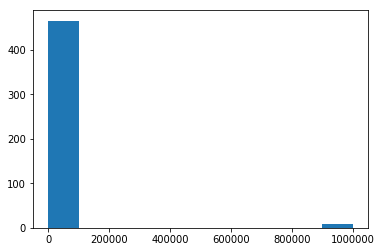

In [196]:
columns_name = ['APO_ID', 'U', 'V', 'W', 'V_total' ]
df = pd.read_table('gc_velocities.txt', sep='\s+', names=columns_name, index_col=False, header=None)
HVS = df.loc[df['V_total'] > 500]
plt.hist(HVS.V_total)
print(HVS.V_total)

### **Galactocentric coordinate**
Com todos os parâmetros necessários neste paso determinamos a velocidade en coordenadas galactocentricas, para isso iremos fazer uso da rutina em python do astropy. 

In [103]:
from IPython.display import IFrame
IFrame(src='http://docs.astropy.org/en/stable/coordinates/index.html', width=1000, height=100)

In [104]:
from IPython.display import IFrame
IFrame(src='http://docs.astropy.org/en/stable/coordinates/galactocentric.html#', width=1000, height=100)

In [4]:
# Colocando os pacotes necessários para rodar o codigo
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
# using astropy
import astropy.coordinates as coord
import astropy.units as u

In [ ]:
# Rodando o codigo mostrado no site do astropy 
c1 = coord.ICRS(ra=89.014303*u.degree, dec=13.924912*u.degree,
                distance=(37.59*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=372.72*u.mas/u.yr,
                pm_dec=-483.69*u.mas/u.yr,
                radial_velocity=0.37*u.km/u.s)

In [ ]:
gc1 = c1.transform_to(coord.Galactocentric)
print(gc1.v_x, gc1.v_y, gc1.v_z)

#### **Testando com os valores de velocidades galactocentricas obtidos para o Large Magellanic Cloud (LMC) e o Small Magellanic Cloud (SMC) no artigo doi:10.1088/0004-6256/137/5/4339** 
#### **Dados necessários para o LMC**
Posição 

1. RA  = +89.33 graus
2. DEC = -67.22 graus

Distância

3. distancia = 50100 pc

Movimento proprios

movimento proprio para velocidade de rotação  50 km/s

4. mu_alpha_cos_delta = +1.82 +- 0.13 mas/yr
5. mu_delta = +0.39 +- 0.15 mas/yr

movimento proprio para velocidade de rotação  120 km/s

6. mu_alpha_cos_delta = +1.61 +- 0.13 mas/yr
7. mu_delta = +0.60 +- 0.15 mas/yr

Velocidade radial 

8. VR = +287.0 km/s

In [ ]:
# velocidade galactocentrica para o LMC com velocidade de rotação de 50 km/s
C_LMC50_1 = coord.ICRS(ra=81.90*u.degree, dec=-69.87*u.degree,
                distance=50100*u.pc,
                pm_ra_cosdec=1.82*u.mas/u.yr,
                pm_dec=-0.39*u.mas/u.yr,
                radial_velocity=262.1*u.km/u.s)
gc_LMC50_1 = C_LMC50_1.transform_to(coord.Galactocentric)
print(gc_LMC50_1.v_x, gc_LMC50_1.v_y, gc_LMC50_1.v_z)

In [ ]:
# considerando os valores do artigo
v_sun = coord.CartesianDifferential([14.0, 12.24, 7.25]*u.km/u.s)
gc_frame_lmc50 = coord.Galactocentric(galcen_distance=8.2*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=25*u.pc)
gc_LMC50_2 = C_LMC50_1.transform_to(gc_frame_lmc50)
print(gc_LMC50_2.v_x, gc_LMC50_2.v_y, gc_LMC50_2.v_z)

# Artigo Gaia DR2 in 6D: Searching for the fastest stars in the galaxy
Posição 

1. RA  = 45.13214374784831 graus
2. DEC = 0.13785096598403554 graus

Distância

3. distancia = 382.4321158364128 pc

Movimento proprios

movimento proprio para velocidade de rotação  50 km/s

4. mu_alpha_cos_delta = 4.782390524372778 mas/yr
5. mu_delta = 18.790211615251437 mas/yr

Velocidade radial 

8. VR = 33.84043726251102 km/s

In [ ]:
# velocidade galactocentrica para a primeira estrela do catalogo gaia (Marchetti)
GAIA_1 = coord.ICRS(ra=45.13214374784831*u.degree, dec=0.13785096598403554*u.degree,
                distance=382.4321158364128*u.pc,
                pm_ra_cosdec=4.782390524372778*u.mas/u.yr,
                pm_dec=18.790211615251437*u.mas/u.yr,
                radial_velocity=33.84043726251102*u.km/u.s)
gc_GAIA_1 = GAIA_1.transform_to(coord.Galactocentric)
print(gc_GAIA_1.v_x, gc_GAIA_1.v_y, gc_GAIA_1.v_z)

In [ ]:
# considerando os valores do artigo
v_sun = coord.CartesianDifferential([14.0, 250.24, 7.25]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8.2*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=25*u.pc)
gc_GAIA_1C = GAIA_1.transform_to(gc_frame)
print(gc_GAIA_1C.v_x, gc_GAIA_1C.v_y, gc_GAIA_1C.v_z)

In [ ]:
# velocidade galactocentrica para a segunda estrela do catalogo gaia (Marchetti)
GAIA_2 = coord.ICRS(ra=45.05816745630085*u.degree, dec=0.12740379563087656*u.degree,
                distance=573.9735889753617*u.pc,
                pm_ra_cosdec=6.399015950035163*u.mas/u.yr,
                pm_dec=-12.94271166934367*u.mas/u.yr,
                radial_velocity=4.5726744498926255*u.km/u.s)
gc_GAIA_2 = GAIA_2.transform_to(gc_frame)
U = gc_GAIA_2.v_x
V = gc_GAIA_2.v_y
W = gc_GAIA_2.v_z
V_total = np.sqrt(U**2 + V**2 + W**2)
print(U, V, W, V_total)

In [ ]:
np.sqrt(17.877407021113946**2 + 212.54059105492033**2 + -4.06084412139914**2)